# CS541: Applied Machine Learning, Spring 2025, Lab 5

Lab 5 is an exercise that explores Gaussian Mixture Models (GMM) which is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.
They are flexible can model elliptical clusters, making them suitable for data with varying cluster shapes and sizes.

We will be working on creating a GMM from scratch and utilizing the
Expectation Likelihood algorithm to do this.


**Lab Grading**

Labs are hands-on exercises designed to provide guided experience in key concepts through this class.  You are graded based on in-lab participation (not correctness), and **are required to submit** your lab work after class, before Friday of that week.  *Make sure you fill out the attendence form before leaving class*.

For students who miss a lab, you can submit a make-up lab on gradescope by the Friday directly following the lab for partial credit.  Please see the syllabus for the lab grading policy.

In [23]:
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from sklearn import datasets

In [24]:
def jitter(x):
    return x + np.random.uniform(low=-0.05, high=0.05, size=x.shape)

(1000, 2)


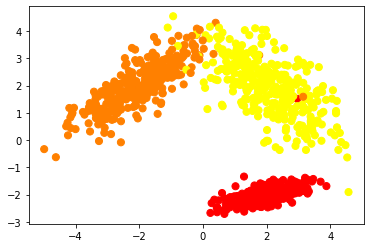

In [25]:
X, y = datasets.make_classification(n_samples=1000, n_features=2, n_classes=3,
                                     n_clusters_per_class=1, n_redundant=0,class_sep=2,
                                     random_state=43)
print(X.shape)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

In [26]:
class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k # number of components
        self.max_iter = int(max_iter) # Number of iterations

    def initialize(self, X):
        # set it as the shape of the numpy array of X
        self.shape = X.shape
        # n has the number of rows while m has the number of columns of dataset X
        self.n, self.m = self.shape

        # Initial cluster weights (phi): Equal probability for each cluster
        # Lets make an array of size k and fill all the values with the equal probability
        self.phi = np.full(shape=(self.k,), fill_value=1 / self.k)

        # Responsibility matrix (weights): Each data point's probability of belonging to each cluster
        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        # Lets make an array of size (self.n, self.k) and fill all the values with the equal probability
        self.weights = np.full(shape=(self.n, self.k), fill_value=1 / self.k)

        # Randomly select initial means (μ) from dataset
        # Select k unique random indices from the dataset to initialize cluster means
        random_row = np.random.choice(self.n, self.k, replace=False)

        # initial value of mean of k Gaussians
        # Let's make a list that takes in all the rows in X that correspond to the rows from random_row
        self.mu = [X[row_index,:] for row_index in random_row]

        # initial value of covariance matrix of k Gaussians
        # We want to get the covariance of k gaussians you can use numpy's built in function for this, and consider transposing your X array
        # before getting the covariance
        self.sigma = [np.cov(X.T, bias=True) for _ in range(self.k)]

    # E-Step: update weights holding phi, mu and sigma constant
    def e_step(self, X):
        # updated weights or P(Xi/Ci=j)
        self.weights = self.predict_proba(X)

    # M-Step: update phi, meu and sigma holding weights constant
    def m_step(self, X):
        # mean of the sum of the probability of all data points wrt to one cluster is the newly updated probability of cluster k or (phi)k
        # consider getting the mean of the self.weights across the rows
        self.phi = self.weights.mean(axis=0)

        for i in range(self.k):
            weight = self.weights[:, i]

            #Lets get the sum of the weights
            total_weight = weight.sum()

            # Now let's multiply X by the weight, and sum along the rows, and we divide this all by the total weight
            self.mu[i] = (X * weight[:, np.newaxis]).sum(axis=0) / total_weight

            # Calculate the covariance of sigma[i] using the vector weights
            self.sigma[i] = np.cov(X.T, aweights=(weight / total_weight).flatten(), bias=True)

    # predicts probability of each data point wrt each cluster
    def predict_proba(self, X):
        # Creates a n*k matrix denoting probability of each point wrt each cluster
        # Let's first create a dummy array filled with zeros of size n*k
        likelihood = np.zeros((self.n, self.k))
        for i in range(self.k):
            #Use the multivariate_normal function from scipy and set the mean to the self.m at the i'th and self.sigma also at the i'th cluster
            distribution = multivariate_normal(mean=self.mu[i], cov=self.sigma[i])

            # pdf : probability denisty function
            # Use the distribution we just defined and use the pdf function from it and pass the X value to it
            # You can read about the multivariate_normal function from scipy and you can see what methods you can call
            likelihood[:,i] = distribution.pdf(X)

        # Now you want to multiply the likelihood by the self.phi attribute we defined previously
        numerator = likelihood * self.phi

        # Currently we are summing along the columns, we also want to utilize np.newaxis
        # on the result, let's use it to increase the dimension by 1, e.g. var[:, np.newaxis]
        denominator = numerator.sum(axis=1)[:, np.newaxis]

        # Now simply divide the numerator by the denominator!
        weights = numerator / denominator
        return weights

    # predict function
    def predict(self, X):
        weights = self.predict_proba(X)
        # datapoint belongs to cluster with maximum probability
        # returns this value
        return np.argmax(weights, axis=1)


    # responsible for clustering the data points correctly
    def fit(self, X, y):
        # initialise parameters like weights, phi, meu, sigma of all Gaussians in dataset X
        self.initialize(X)
        plt.figure(figsize=(16, 25))
        for iteration in range(self.max_iter):
            permutation = np.array([mode(y[gmm.predict(X) == i]).mode.item() for i in range(gmm.k)])
            permuted_prediction = permutation[gmm.predict(X)]
            print('\nThe accuracy of the permuted prediction against target before iteration ',iteration+1,end="")
            print(': ',np.mean(y == permuted_prediction))
            print('\n')
            plt.title(' Iteration Cluster')
            plt.subplot(5,3,iteration+1)
            clusters=permuted_prediction
            plt.xlabel('X[0]')
            plt.ylabel('X[1]')
            plt.scatter(jitter(X[:, 0]), jitter(X[:, 1]), c=clusters, cmap=plt.cm.get_cmap('brg'),marker='.')
            plt.grid()
            plt.tight_layout()
            # iterate to update the value of P(Xi/Ci=j)
            self.e_step(X)
            # iterate to update the value of (phi)k, meu and sigma as the clusters shift
            self.m_step(X)

/var/folders/qf/yh559xpx4dv12z0mkyw5cvr80000gn/T/ipykernel_16364/1221597716.py:96: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  permutation = np.array([mode(y[gmm.predict(X) == i]).mode.item() for i in range(gmm.k)])
/var/folders/qf/yh559xpx4dv12z0mkyw5cvr80000gn/T/ipykernel_16364/1221597716.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(jitter(X[:, 0]), jitter(X[:, 1]), c=clusters, cmap=plt.cm.get_cmap('brg'),marker='.')



The accuracy of the permuted prediction against target before iteration  1:  0.665



The accuracy of the permuted prediction against target before iteration  2:  0.74



The accuracy of the permuted prediction against target before iteration  3:  0.709



The accuracy of the permuted prediction against target before iteration  4:  0.761



The accuracy of the permuted prediction against target before iteration  5:  0.794



The accuracy of the permuted prediction against target before iteration  6:  0.817



The accuracy of the permuted prediction against target before iteration  7:  0.833



The accuracy of the permuted prediction against target before iteration  8:  0.851



The accuracy of the permuted prediction against target before iteration  9:  0.875



The accuracy of the permuted prediction against target before iteration  10:  0.901



The accuracy of the permuted prediction against target before iteration  11:  0.92



The accuracy of the permuted prediction against targe

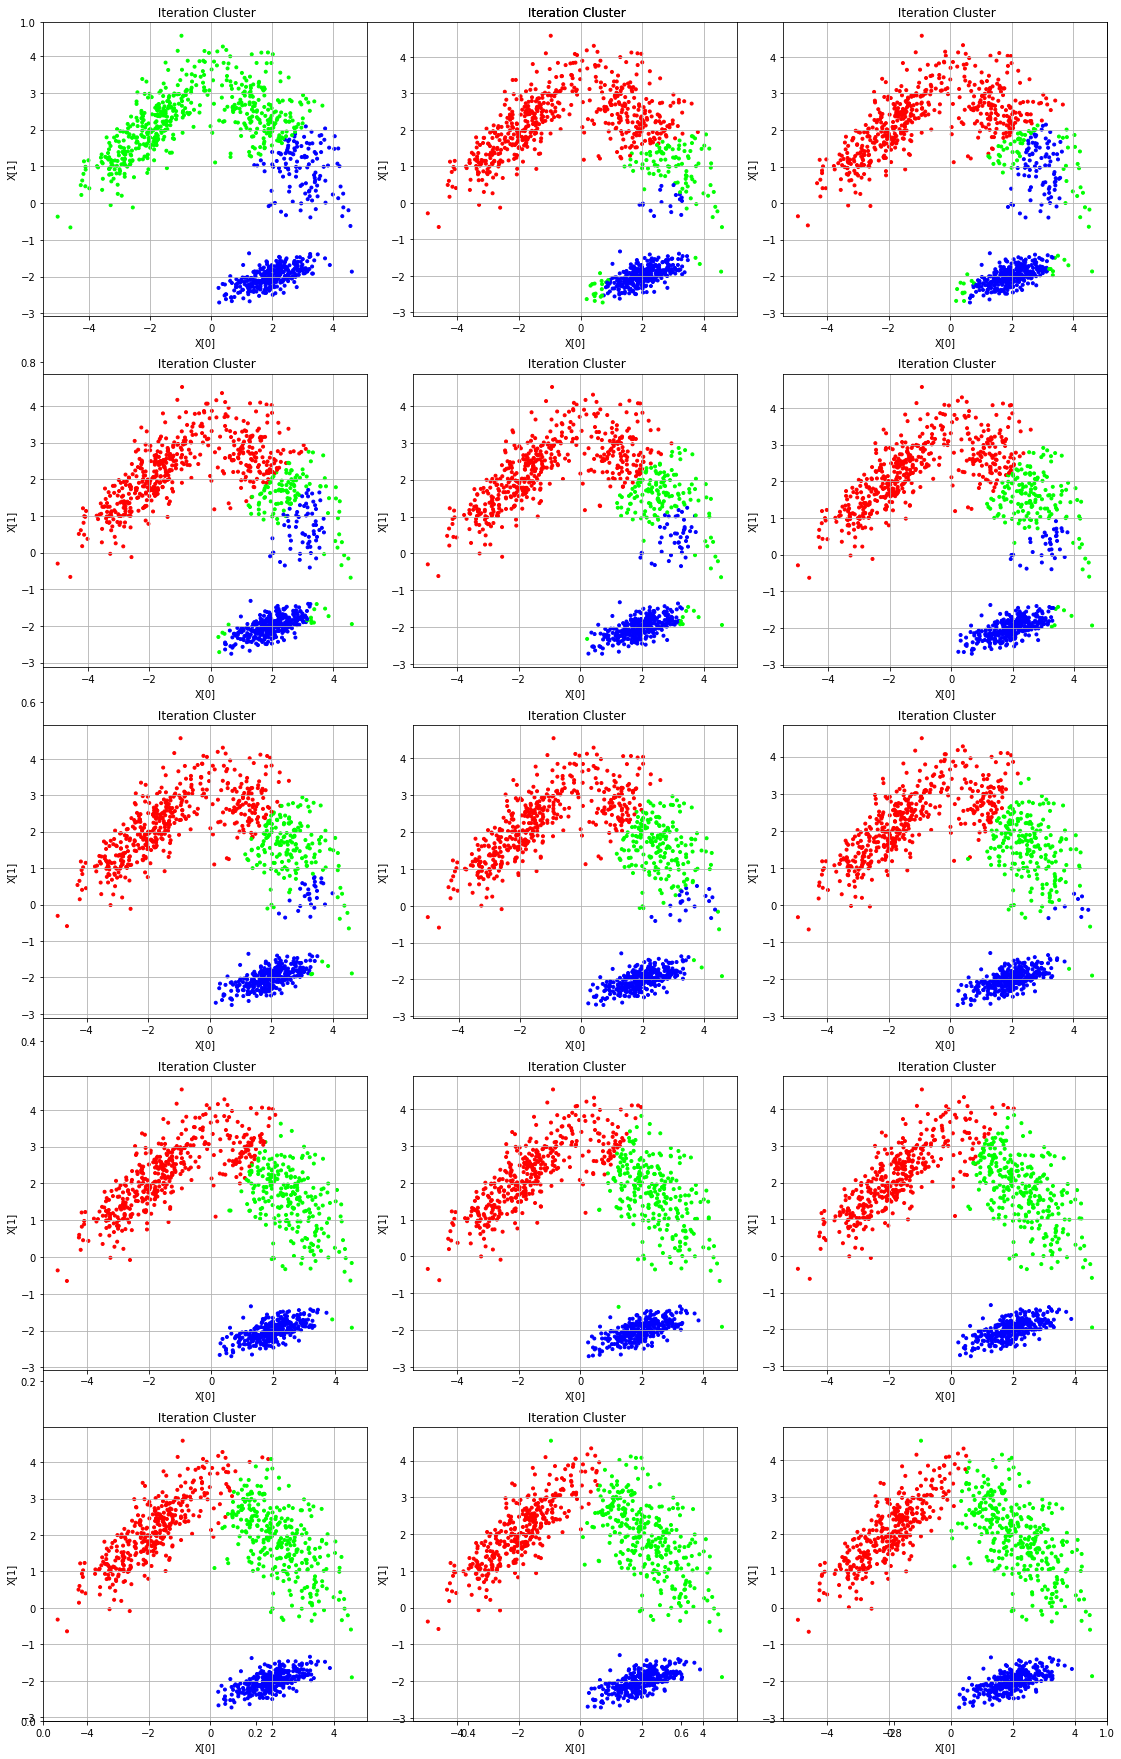

In [27]:
np.random.seed(42)
gmm = GMM(k=3, max_iter=15)
gmm.fit(X,y)